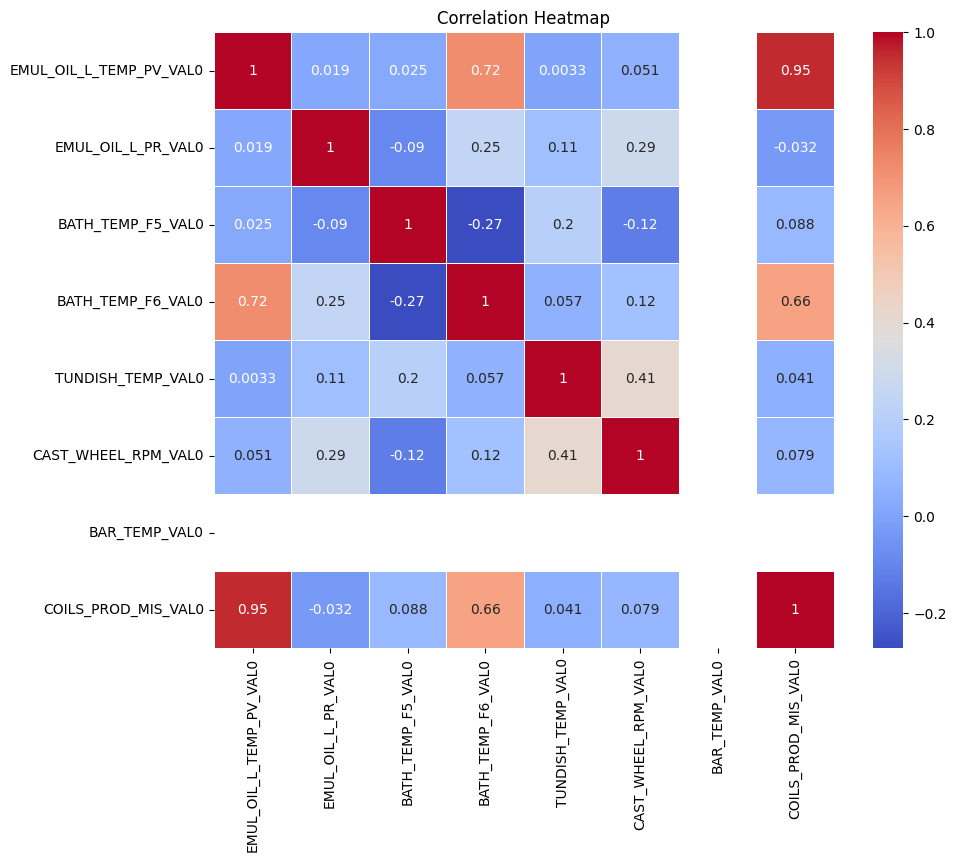

Random Forest R^2: 0.9693184
Random Forest MAE: 0.26333333333333325


c:\Users\HP\anaconda3\envs\pycaret_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Neural Network R^2: 0.695299001429903
Neural Network MAE: 0.8253040313720703
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Future Predictions (Random Forest): [7.04 7.88 7.83 7.69 7.63]
Future Predictions (Neural Network): [[6.4725757]
 [7.9764376]
 [8.616643 ]
 [8.610676 ]
 [8.050422 ]]


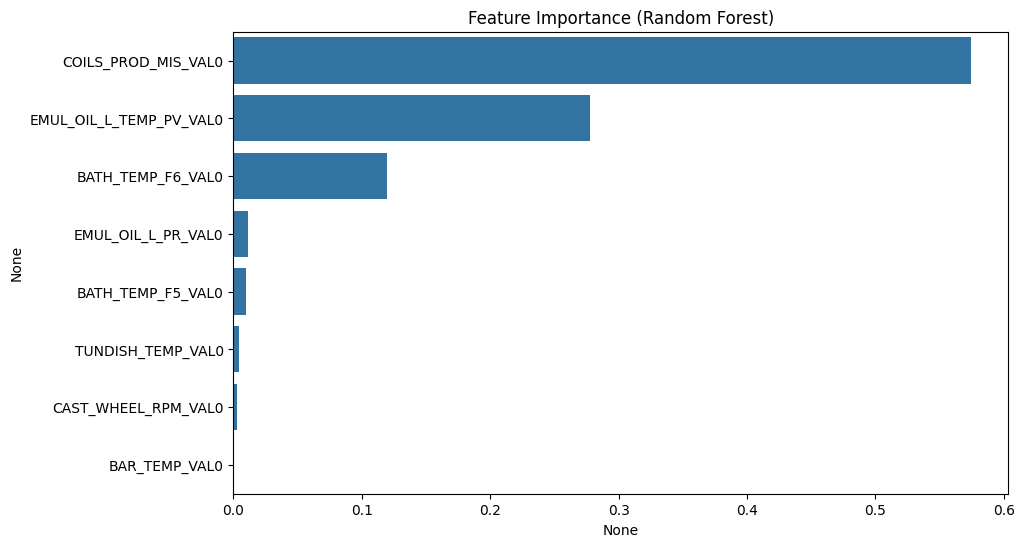

Random Forest Cross-Validation R^2 Scores: [ -9.854525     0.819625     0.491        0.78641667 -12.975125  ]
Mean CV R^2: -4.1465216666666675


In [ ]:
# Required libraries
from imblearn.over_sampling import SMOTE, RandomOverSampler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from io import StringIO
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.layers import LSTM
from flask import Flask, request, jsonify
import shap
import requests
import joblib
import numpy as np
from keras.models import load_model
from flask import Flask, request, jsonify
import threading
import time

# Sample plaintext dataset
data =   """
timestamp,timestamp_utc,EMUL_OIL_L_TEMP_PV_VAL0,EMUL_OIL_L_PR_VAL0,BATH_TEMP_F5_VAL0,BATH_TEMP_F6_VAL0,TUNDISH_TEMP_VAL0,CAST_NUMBER_MIS_VAL0,QUENCH_CW_FLOW_ENTRY_VAL0,QUENCH_CW_FLOW_EXIT_VAL0,CAST_WHEEL_RPM_VAL0,BAR_TEMP_VAL0,COILS_PROD_MIS_VAL0
05-03-2024 00:02,04-03-2024 18:32,67.73565674,2.276472092,738.7989502,691.8505859,583.2075195,566609,-1.125,-47.75,2.110235691,125,2
05-03-2024 00:07,04-03-2024 18:37,67.77101135,2.260812759,748.2418213,679.6936035,595.4628906,566609,-1.125,-47.75,2.122119188,125,2
05-03-2024 00:12,04-03-2024 18:42,67.80044556,2.252389908,736.7755127,668.3122559,588.838623,566609,-1.125,-47.75,2.121313572,125,3
05-03-2024 00:17,04-03-2024 18:47,67.82884216,2.26187706,709.831665,669.0378418,570.4362793,566609,-1.125,-47.75,2.136419773,125,3
05-03-2024 00:22,04-03-2024 18:52,67.82174683,2.261737823,712.7718506,690.2080078,604.7558594,566609,-1.125,-47.75,2.123327732,125,3
05-03-2024 00:27,04-03-2024 18:57,67.88471985,2.290927887,717.4547119,723.7646484,566.9379883,566609,-1.125,-47.75,2.116680861,125,3
05-03-2024 00:32,04-03-2024 19:02,67.8624115,2.27914238,696.4329834,755.0986328,600.0239258,566609,-1.125,-47.75,2.146490574,125,4
05-03-2024 00:37,04-03-2024 19:07,67.87846375,2.258300781,668.2738037,763.1408691,578.7744141,566609,-1.125,-47.75,2.123730421,125,4
05-03-2024 00:41,04-03-2024 19:11,67.88829041,2.265068054,703.4876709,764.5930176,582.5720215,566609,-1.125,-47.75,2.125946045,125,4
05-03-2024 00:46,04-03-2024 19:16,67.8921051,2.279310226,711.2523193,765.7736816,578.0820313,566609,-1.125,-47.75,2.107214451,125,4
05-03-2024 00:51,04-03-2024 19:21,67.90722656,2.243053436,673.2147217,769.4433594,585.2636719,566609,-1.125,-47.75,2.100769043,125,5
05-03-2024 00:56,04-03-2024 19:26,67.90138245,2.27255249,724.1744385,774.4763184,611.0527344,566609,-1.125,-47.75,2.123931885,125,5
05-03-2024 01:00,04-03-2024 19:30,67.92308044,2.254295349,753.2344971,776.4707031,610.0844727,566609,-1.125,-47.75,2.148101807,125,5
05-03-2024 01:05,04-03-2024 19:35,67.91824341,2.292354584,704.9195557,778.807373,568.8249512,566609,-1.125,-47.75,2.124737501,125,5
05-03-2024 01:10,04-03-2024 19:40,67.91937256,2.297815323,744.2598877,778.5847168,573.310791,566609,-1.125,-47.75,2.122320652,125,6
05-03-2024 01:15,04-03-2024 19:45,67.93440247,2.298854828,673.5552979,776.2202148,613.9138184,566609,-1.125,-47.75,2.160186768,125,6
05-03-2024 01:19,04-03-2024 19:49,67.93701172,2.272863388,674.1292725,777.458252,569.4602051,566609,-1.125,-47.75,2.122723341,125,6
05-03-2024 01:24,04-03-2024 19:54,67.95935059,2.282300949,679.7637939,774.4052734,583.6940918,566609,-1.125,-47.75,2.119903564,125,6
05-03-2024 01:29,04-03-2024 19:59,67.96466064,2.278020859,760.52771,770.2919922,604.0498047,566609,-1.125,-47.75,2.123931885,125,7
05-03-2024 01:34,04-03-2024 20:04,67.95056152,2.279182434,701.1243896,767.0668945,598.5561523,566609,-1.125,-47.75,2.156964064,125,7
05-03-2024 01:38,04-03-2024 20:08,67.94445801,2.257387161,692.4029541,764.208252,578.1347656,566609,-1.125,-47.75,2.126147509,125,7
05-03-2024 01:43,04-03-2024 20:13,67.97271729,2.273651123,724.2979736,763.526123,603.5004883,566609,-1.125,-47.75,2.112451077,125,7
05-03-2024 01:48,04-03-2024 20:18,68.00398254,2.244562149,748.9459229,760.3017578,571.7729492,566609,-1.125,-47.75,2.126751661,125,8
05-03-2024 01:53,04-03-2024 20:23,68.00224304,2.246164322,718.270874,756.8674316,559.6650391,566609,-1.125,-47.75,2.11365962,125,8
05-03-2024 01:57,04-03-2024 20:27,68.02412415,2.251245499,747.1749268,754.5568848,597.9086914,566609,-1.125,-47.75,2.110839844,125,8
05-03-2024 02:02,04-03-2024 20:32,68.02487183,2.289331436,745.0406494,751.7119141,598.8837891,566609,-1.125,-47.75,2.127960205,125,8
"""

# Load the dataset
df = pd.read_csv(StringIO(data), sep=',')

# Convert the 'timestamp' column to datetime format and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Feature Selection (selecting a few relevant features)
selected_features = [
    'EMUL_OIL_L_TEMP_PV_VAL0', 'EMUL_OIL_L_PR_VAL0',
    'BATH_TEMP_F5_VAL0', 'BATH_TEMP_F6_VAL0', 'TUNDISH_TEMP_VAL0',
    'CAST_WHEEL_RPM_VAL0', 'BAR_TEMP_VAL0', 'COILS_PROD_MIS_VAL0'
]

# Heatmap for correlation
plt.figure(figsize=(10, 8))
sns.heatmap(df[selected_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Prepare data for Machine Learning
X = df[selected_features]
y = df['COILS_PROD_MIS_VAL0']  # Assuming this is the target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Use RandomOverSampler as an alternative to SMOTE
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Random Forest Metrics
rf_r2 = r2_score(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)

print("Random Forest R^2:", rf_r2)
print("Random Forest MAE:", rf_mae)

# Neural Network (simple feed-forward)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='linear'))

nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, verbose=0)

# Predictions using Neural Network
y_pred_nn = nn_model.predict(X_test_scaled)

# Neural Network Metrics
nn_r2 = r2_score(y_test, y_pred_nn)
nn_mae = mean_absolute_error(y_test, y_pred_nn)

print("Neural Network R^2:", nn_r2)
print("Neural Network MAE:", nn_mae)

# Predicting future coils produced (5 future steps)
future_steps = 5
future_features = X.tail(future_steps)  # Using the last 'future_steps' rows as input for prediction
future_features_scaled = scaler.transform(future_features)

# Random Forest predictions
future_predictions_rf = rf_model.predict(future_features)

# Neural Network predictions
future_predictions_nn = nn_model.predict(future_features_scaled)

print("Future Predictions (Random Forest):", future_predictions_rf)
print("Future Predictions (Neural Network):", future_predictions_nn)


# Feature importance from the Random Forest model
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importance (Random Forest)')
plt.show()
#goal-Understand which casting parameters are driving the predictions.


# Random Forest cross-validation
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print("Random Forest Cross-Validation R^2 Scores:", rf_cv_scores)
print("Mean CV R^2:", np.mean(rf_cv_scores))

# Neural Network cross-validation
# (Typically, cross-validation with deep learning models may be computationally expensive, but you can evaluate on different test sets as an alternative.)

#Goal: Ensure the model isn’t overfitting and performs well on unseen data.

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid search for Random Forest
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Random Forest Parameters:", grid_search.best_params_)
 #Goal: Find the optimal parameters for both Random Forest and the neural network.


# Example LSTM architecture (if you want to experiment with time-series models)
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1), y_train, epochs=50, batch_size=16, verbose=1)
#Goal: Incorporate sequential data modeling to capture trends and lags in your time-series data.


explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

#Goal: Gain insights into how each casting parameter influences the predictions.


# Simulate changes in casting parameters (for example)
simulated_params = future_features.copy()
simulated_params['EMUL_OIL_L_TEMP_PV_VAL0'] += 5  # Example: increase oil temperature by 5 units

# Predict the impact of simulated changes
simulated_predictions_rf = rf_model.predict(simulated_params)
simulated_predictions_nn = nn_model.predict(scaler.transform(simulated_params))

print("Simulated Predictions (Random Forest):", simulated_predictions_rf)
print("Simulated Predictions (Neural Network):", simulated_predictions_nn)

import os
print(os.getcwd())

# Save the Random Forest model
import joblib
joblib.dump(rf_model, 'random_forest_model.pkl')

# Save the Neural Network model
nn_model.save('neural_network_model.h5')  # This saves the Keras model
# Load pre-trained models
from keras.models import load_model

rf_model = joblib.load('random_forest_model.pkl')
nn_model = load_model('neural_network_model.h5')  # Ensure this matches your save method


# Save the Neural Network model
nn_model.save('neural_network_model.keras')  # Change to .keras format

# Initialize Flask app
app = Flask(__name__)

# Load pre-trained models
rf_model = joblib.load('random_forest_model.pkl')
nn_model = load_model('neural_network_model.keras')  # Ensure this matches your save method
nn_model.compile(optimizer='adam', loss='mean_squared_error')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.json['data']
        print("Received data:", data)  # Debugging statement
        X_new = np.array(data).reshape(1, -1)

        # Make predictions
        rf_prediction = rf_model.predict(X_new)
        nn_prediction = nn_model.predict(X_new)

        return jsonify({
            'rf_prediction': rf_prediction.tolist(),
            'nn_prediction': nn_prediction.tolist()
        })
    except Exception as e:
        print("Error during prediction:", str(e))  # Log the error
        return jsonify({'error': str(e)}), 500  # Return an error code

def run_app():
    app.run(debug=True, use_reloader=False)  # Prevent app from starting twice

# Start the Flask app in a new thread
thread = threading.Thread(target=run_app)
thread.start()

# Give the server a moment to start
time.sleep(1)


# Example input data for prediction
input_data = {
    'data': [
        [67.73565674, 2.276472092, 738.7989502, 691.8505859, 583.2075195, 2.110235691, 125, 2],
        [67.77101135, 2.260812759, 748.2418213, 679.6936035, 595.4628906, 2.122119188, 125, 2],
        [67.80044556, 2.252389908, 736.7755127, 668.3122559, 588.838623, 2.121313572, 125, 3],
        [67.82884216, 2.26187706, 709.831665, 669.0378418, 570.4362793, 2.136419773, 125, 3],
        [67.82174683, 2.261737823, 712.7718506, 690.2080078, 604.7558594, 2.123327732, 125, 3],
        [67.88471985, 2.290927887, 717.4547119, 723.7646484, 566.9379883, 2.116680861, 125, 3],
        [67.8624115, 2.27914238, 696.4329834, 755.0986328, 600.0239258, 2.146490574, 125, 4],
        [67.87846375, 2.258300781, 668.2738037, 763.1408691, 578.7744141, 2.123730421, 125, 4],
        [67.88829041, 2.265068054, 703.4876709, 764.5930176, 582.5720215, 2.125946045, 125, 4],
        [67.8921051, 2.279310226, 711.2523193, 765.7736816, 578.0820313, 2.107214451, 125, 4],
        [67.90722656, 2.243053436, 673.2147217, 769.4433594, 585.2636719, 2.100769043, 125, 5],
        [67.90138245, 2.27255249, 724.1744385, 774.4763184, 611.0527344, 2.123931885, 125, 5],
        [67.92308044, 2.254295349, 753.2344971, 776.4707031, 610.0844727, 2.148101807, 125, 5],
        [67.91824341, 2.292354584, 704.9195557, 778.807373, 568.8249512, 2.124737501, 125, 5],
        [67.91937256, 2.297815323, 744.2598877, 778.5847168, 573.310791, 2.122320652, 125, 6],
        [67.93440247, 2.298854828, 673.5552979, 776.2202148, 613.9138184, 2.160186768, 125, 6],
        [67.93701172, 2.272863388, 674.1292725, 777.458252, 569.4602051, 2.122723341, 125, 6],
        [67.95935059, 2.282300949, 679.7637939, 774.4052734, 583.6940918, 2.119903564, 125, 6],
        [67.96466064, 2.278020859, 760.52771, 770.2919922, 604.0498047, 2.123931885, 125, 7],
        [67.95056152, 2.279182434, 701.1243896, 767.0668945, 598.5561523, 2.156964064, 125, 7],
        [67.94445801, 2.257387161, 692.4029541, 764.208252, 578.1347656, 2.126147509, 125, 7],
        [67.97271729, 2.273651123, 724.2979736, 763.526123, 603.5004883, 2.112451077, 125, 7],
        [68.00398254, 2.244562149, 748.9459229, 760.3017578, 571.7729492, 2.126751661, 125, 8],
        [68.00224304, 2.246164322, 718.270874, 756.8674316, 559.6650391, 2.11365962, 125, 8],
        [68.02412415, 2.251245499, 747.1749268, 754.5568848, 597.9086914, 2.110839844, 125, 8],
        [68.02487183, 2.289331436, 745.0406494, 751.7119141, 598.8837891, 2.127960205, 125, 8]
    ]
}

# Print all input data in the specified format
for idx, data_point in enumerate(input_data['data']):
    print(f"Example Input Data {idx + 1}: {data_point}")

# Prepare a list to collect all predictions
all_predictions = []

# Iterate over all input data points
for idx, data_point in enumerate(input_data['data']):
    # Reshape the input data point for prediction
    X_new = np.array(data_point).reshape(1, -1)

    # Make a POST request to the Flask API for each input data point
    try:
        response = requests.post('http://127.0.0.1:500/predict', json={'data': X_new.tolist()})

        # Check if the response was successful
        if response.ok:
            predictions = response.json()
            print(f"Predictions for Example Input Data {idx + 1}: {predictions}")
            all_predictions.append(predictions)
        else:
            print(f"Request failed for Example Input Data {idx + 1} with status code:", response.status_code)
            print("Response text:", response.text)  # Print the response text for debugging

    except requests.exceptions.RequestException as e:
        print(f"Request failed for Example Input Data {idx + 1}:", str(e))

# Process the predictions without type classification
for idx, prediction in enumerate(all_predictions):
    nn_prediction = prediction['nn_prediction'][0][0]  # Accessing the first element of the nested list
    rf_prediction = prediction['rf_prediction'][0]      # Accessing the first element of the list

    # Create a prediction dictionary for each example without type classification
    prediction_dict = {
        'nn_prediction': nn_prediction,
        'rf_prediction': rf_prediction
    }

    # Print the prediction
    print(f"Final Prediction Dictionary for Example Input Data {idx + 1}:", prediction_dict)
